In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from omnetpp.scave import results, chart, utils

class StatType(Enum):
    SCALAR = "count"
    VECTOR = "vector"

DEBUG = True

relPath = "../results/"
cliMeasNames = [("measureReceivedAmount", StatType.VECTOR), ("readSent", StatType.SCALAR), ("commandSent", StatType.SCALAR), ("readResponse", StatType.SCALAR), 
             ("commandResponse", StatType.SCALAR), ("readResponseTimeout", StatType.SCALAR), ("commandResponseTimeout", StatType.SCALAR)]
evilMeasNames = [("measureBlock", StatType.SCALAR), ("measureCompromised", StatType.SCALAR), ("readRequestBlock", StatType.SCALAR), ("readRequestCompromised", StatType.SCALAR), 
                 ("commandRequestBlock", StatType.SCALAR), ("commandRequestCompromised", StatType.SCALAR), ("readResponseBlock", StatType.SCALAR), ("readResponseCompromised", StatType.SCALAR),
                 ("commandResponseBlock", StatType.SCALAR), ("commandResponseCompromised", StatType.SCALAR)]
rep = 30
numClients = 1
numServers = 2

fileNamesSca = []
fileNamesVec = []


name = "MMS_MITM_Wired"
for i in range(0,rep):
    fileNamesSca.append(relPath + name + '-#' + i.__str__() + '.sca')
    fileNamesVec.append(relPath + name + '-#' + i.__str__() + '.vec')
    

if DEBUG:
    print(fileNamesSca)
    print(fileNamesVec)


['../results/MMS_MITM_Wired-#0.sca', '../results/MMS_MITM_Wired-#1.sca', '../results/MMS_MITM_Wired-#2.sca', '../results/MMS_MITM_Wired-#3.sca', '../results/MMS_MITM_Wired-#4.sca', '../results/MMS_MITM_Wired-#5.sca', '../results/MMS_MITM_Wired-#6.sca', '../results/MMS_MITM_Wired-#7.sca', '../results/MMS_MITM_Wired-#8.sca', '../results/MMS_MITM_Wired-#9.sca', '../results/MMS_MITM_Wired-#10.sca', '../results/MMS_MITM_Wired-#11.sca', '../results/MMS_MITM_Wired-#12.sca', '../results/MMS_MITM_Wired-#13.sca', '../results/MMS_MITM_Wired-#14.sca', '../results/MMS_MITM_Wired-#15.sca', '../results/MMS_MITM_Wired-#16.sca', '../results/MMS_MITM_Wired-#17.sca', '../results/MMS_MITM_Wired-#18.sca', '../results/MMS_MITM_Wired-#19.sca', '../results/MMS_MITM_Wired-#20.sca', '../results/MMS_MITM_Wired-#21.sca', '../results/MMS_MITM_Wired-#22.sca', '../results/MMS_MITM_Wired-#23.sca', '../results/MMS_MITM_Wired-#24.sca', '../results/MMS_MITM_Wired-#25.sca', '../results/MMS_MITM_Wired-#26.sca', '../result

Function to create the statistics filter

In [2]:
def createFilter(measNames):
    filter = ""##"type =~ \"scalar\" AND ("
    for i in range(len(measNames)):
        if i != len(measNames)-1:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\" OR "
        else:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\""##)"
    return filter

In [3]:
dataSca = results.read_result_files(fileNamesSca, filter_expression=createFilter(cliMeasNames + evilMeasNames))
dataVec = results.read_result_files(fileNamesVec, filter_expression=createFilter(cliMeasNames + evilMeasNames))
vec = results.get_vectors(dataVec)
scl = results.get_scalars(dataSca)

if DEBUG:
    print(createFilter(cliMeasNames + evilMeasNames))
    scl.to_csv("./outSC.csv", mode="w", header=True)
    vec.to_csv("./outVC.csv", mode="w", header=True)

name =~ "*measureReceivedAmount:vector" OR name =~ "*readSent:count" OR name =~ "*commandSent:count" OR name =~ "*readResponse:count" OR name =~ "*commandResponse:count" OR name =~ "*readResponseTimeout:count" OR name =~ "*commandResponseTimeout:count" OR name =~ "*measureBlock:count" OR name =~ "*measureCompromised:count" OR name =~ "*readRequestBlock:count" OR name =~ "*readRequestCompromised:count" OR name =~ "*commandRequestBlock:count" OR name =~ "*commandRequestCompromised:count" OR name =~ "*readResponseBlock:count" OR name =~ "*readResponseCompromised:count" OR name =~ "*commandResponseBlock:count" OR name =~ "*commandResponseCompromised:count"


Plot client measures for each client aggregating all the repetitions 

In [36]:
def plotBoxWisker(measNames, numClients, numServers, cli = "client", mode = StatType.SCALAR):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(10)
    fig.set_figwidth(25)

    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            box = pd.DataFrame()
            for meas in measNames:
                strElem = ""
                if cli == "evilClient":
                    strElem = cli + ".app[" + str(j) + "]"
                else:
                    strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
                
                if meas[1] == StatType.SCALAR and meas[1] == mode:
                    flt = scl[scl["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box[meas[0]] = flt["value"].reset_index(drop=True)
                elif meas[1] == StatType.VECTOR and meas[1] == mode:
                    flt = vec[vec["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box = None
                    rowNum = 0
                    for row in flt.itertuples():
                        vecValue = pd.Series(row.vecvalue)
                        vecTime = pd.Series(row.vectime)
                        if box is None:
                            box = pd.DataFrame(columns=vecTime)
                        box.loc[rowNum] = vecValue.tolist()
                        rowNum += 1                    
            box = box.replace(np.nan, 0)
            outVec.append(box)
            if DEBUG:
                box.to_csv("./out.csv", mode="w", header=True)
            box.boxplot(ax=axes[j], grid=False, rot=90)
            axes[j].set_title(strElem, fontstyle='italic')
    return outVec

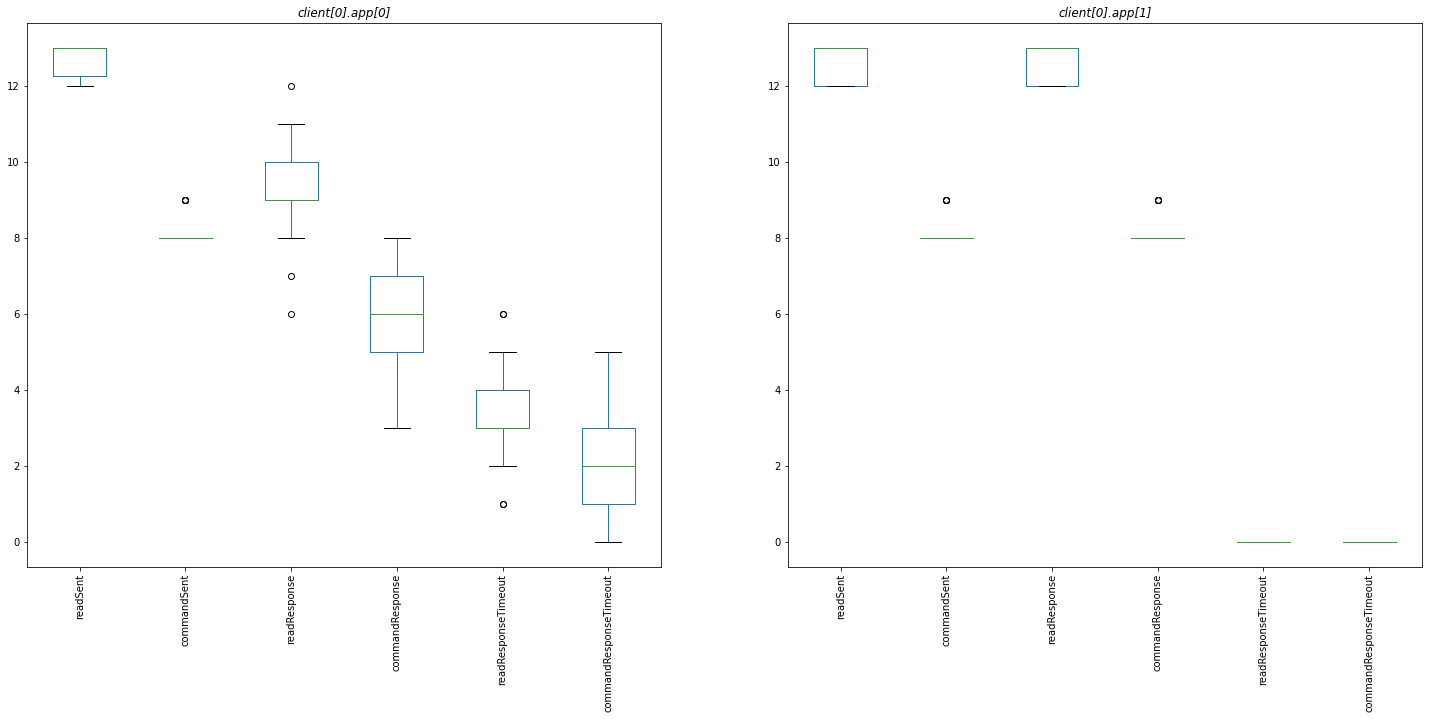

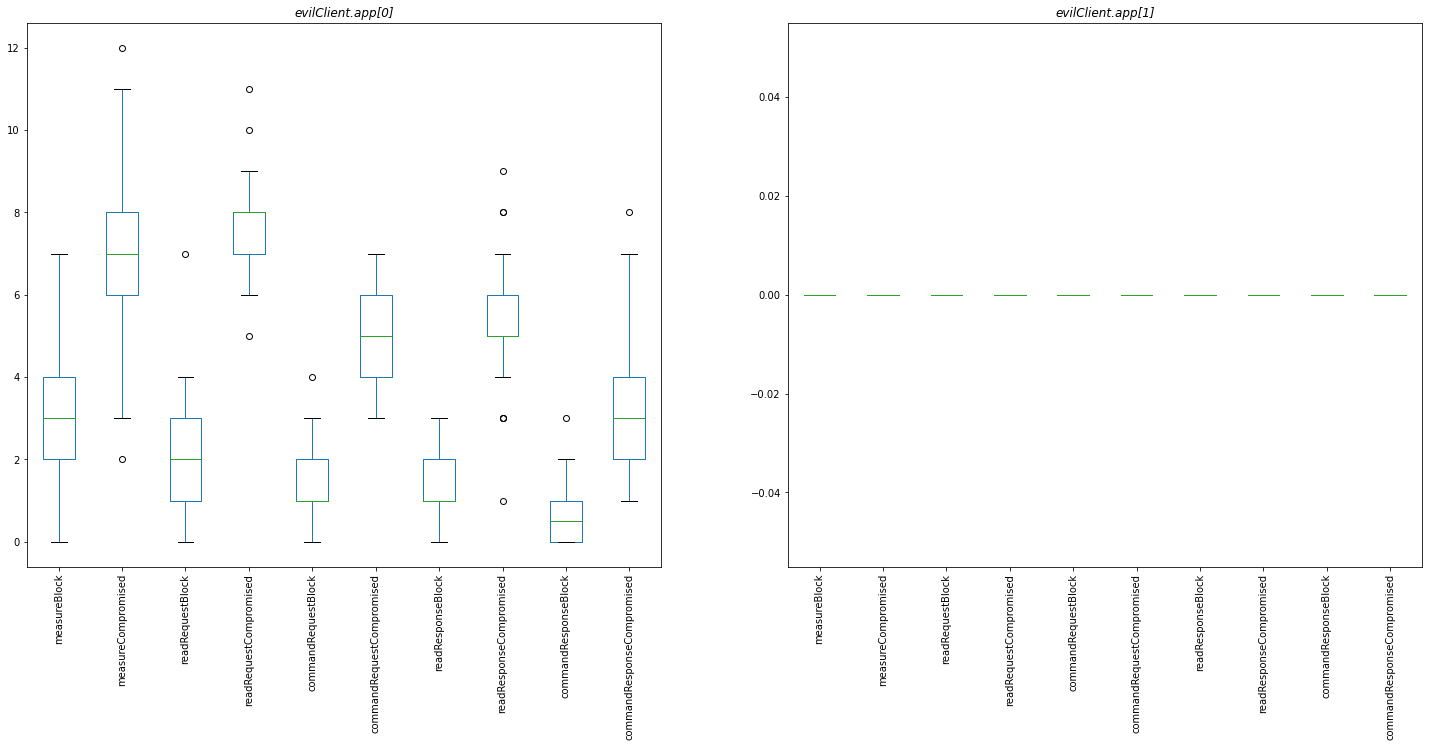

In [37]:
cliScaDfList = plotBoxWisker(cliMeasNames, numClients, numServers)
evilScaDfList = plotBoxWisker(evilMeasNames, 1, numServers, cli="evilClient")


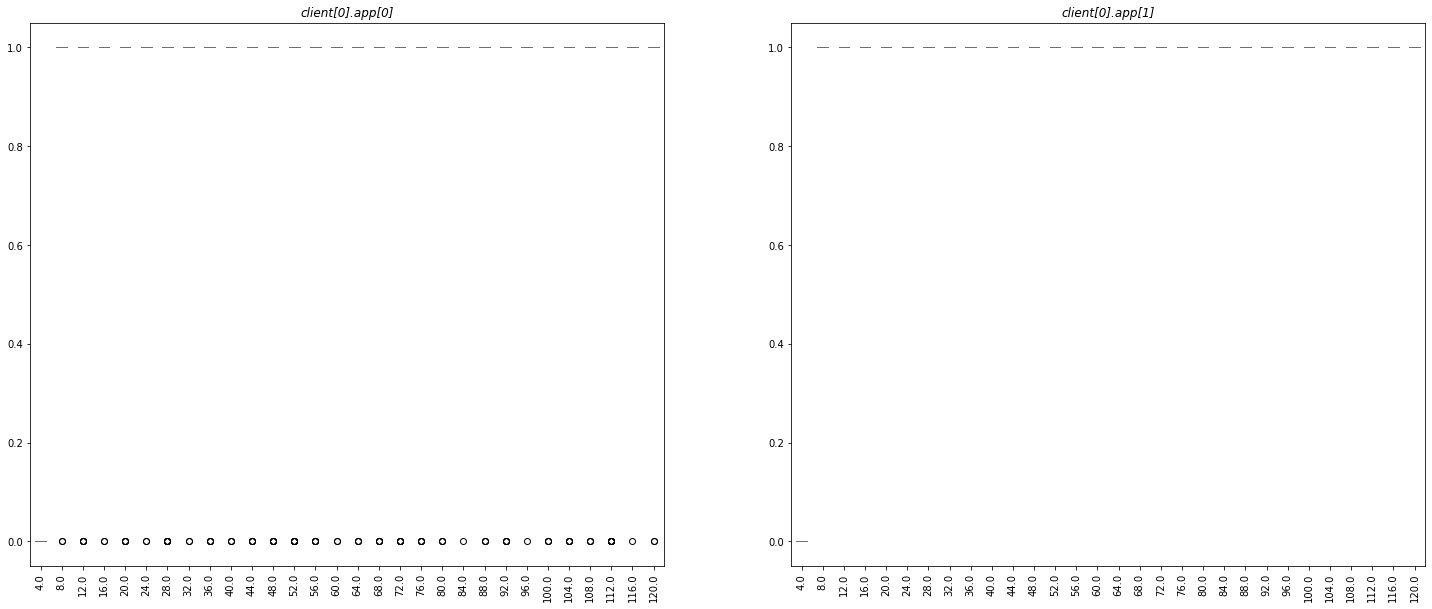

In [38]:
cliVecDfList = plotBoxWisker(cliMeasNames, numClients, numServers, mode=StatType.VECTOR)